# R tutorial: Working with EMODnet OGC Web Services Part 1
#### Written by Pascal Derycke (EMODnet Secretariat) and Laurent Dubroca (Ifremer), edited by Tim Collart (EMODnet Secretariat) and Lennert Schepers (VLIZ)

In [1]:
# load dependencies
## geospatial data handling
library(rgdal)
library(raster)
library(sp)
library(mapdata)
library(maptools)
library(ncdf4)
## general data handling
library(XML)
library(dplyr)
library(tidyr)
library(reshape2)
library(downloader)
## plotting
library(directlabels)
library(rasterVis)
library(ggplot2)
## for display reasons
library(knitr)
library(kableExtra)
library(IRdisplay)
library(repr)
options(repr.plot.wdith=6, repr.plot.height=8)

Loading required package: sp

rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 

Loading required package: maps

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching pac



---


During part 1 of this tutorial, we focus on the Pertuis Charentais Marine Protected Area (MPA) in France. The shapefile for this area can be downloaded from the [World Database on Protected Areas (WDPA)](https://www.protectedplanet.net/555526224).

In [2]:
# download and unzip the shapefile
con = "http://d1gam3xoknrgr2.cloudfront.net/current/WDPA_WDOECM_protected_area_555526224_shp.zip"
download(con,"shapefile.zip", mode = "wb")
unzip("shapefile.zip",exdir="MPA")
file.remove("shapefile.zip")
unzip("MPA/WDPA_WDOECM_protected_area_555526224_shp0.zip", exdir = "MPA")
# read it into R
mpa = readOGR("MPA","WDPA_WDOECM_protected_area_555526224_shp-polygons")
# get the spatial extent of the MPA
xmin <- extent(mpa)@xmin
ymin <- extent(mpa)@ymin
xmax <- extent(mpa)@xmax
ymax <- extent(mpa)@ymax

[1] TRUE

OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/R-tutorial/MPA", layer: "WDPA_WDOECM_protected_area_555526224_shp-polygons"
with 1 features
It has 30 fields


We make some maps to show the location of the MPA.

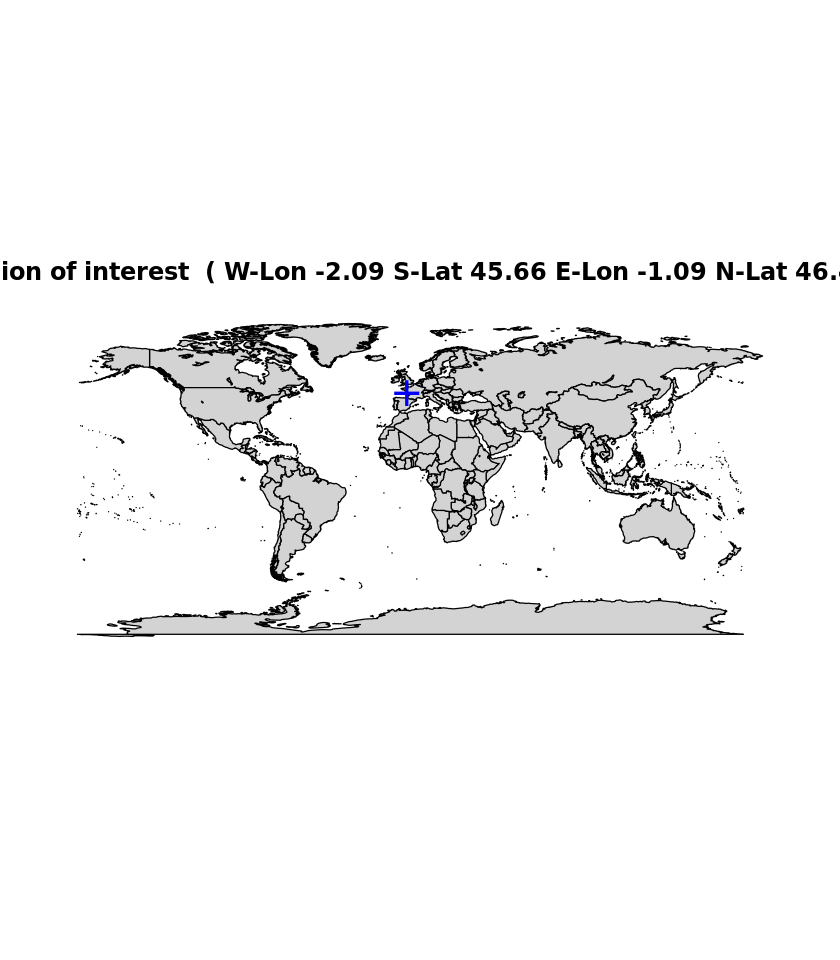

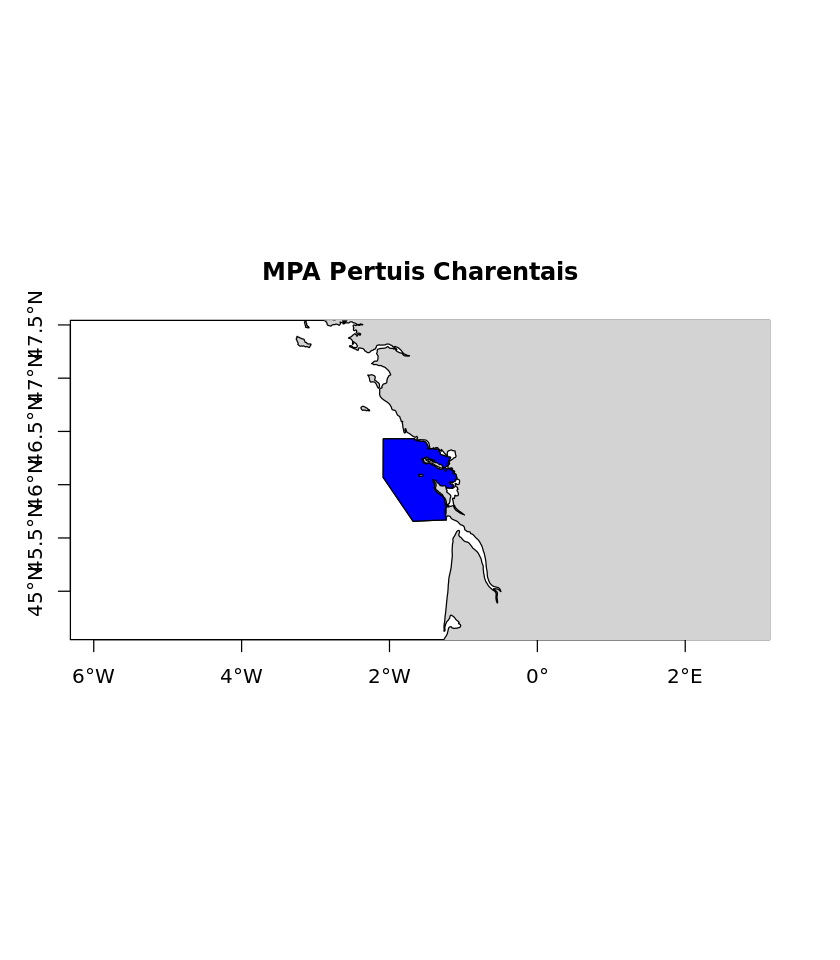

In [3]:
# Localisation at global scale
map("worldHires",col="light grey",fill=T)
points(coordinates(mpa),cex=2,col="blue",pch="+")
title(paste("Region of interest ",
            "( W-Lon",round(xmin,2),
            "S-Lat",round(ymin,2),
            "E-Lon",round(xmax,2),
            "N-Lat",round(ymax,2),")"),cex=.5)

# Localisation at local scale
plot(mpa,xlim=c(xmin-1,xmax+1),ylim=c(ymin-1,ymax+1),axes=T,col="red")
map("worldHires",add=T,col="light grey",fill=T)
plot(mpa,add=T,col="blue")
title(paste("MPA",mpa$ORIG_NAME),cex=.5)

# Working with data from EMODnet bathymetry

## Access raster data through Web Coverage Service (WCS)

Using the EMODnet Bathymetry WCS, we will download the bathymetric data within the MPA.

In [4]:
# Define a function to read in raster data from the EMODnet bathymetry WCS
getbathymetry<-function (name = "emodnet:mean", xmin = 15, xmax = 20.5, ymin = 30, ymax = 32.5){
  bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")
                              
  con <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name,"&crs=EPSG:4326&BBOX=", bbox,
               "&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333", sep = "")
  
  print(con)
  
  stop   
  nomfich <- paste(name, "img.tiff", sep = "_")
  nomfich <- tempfile(nomfich)
  download(con, nomfich, quiet = TRUE, mode = "wb")
  img <- raster(nomfich)
  img[img == 0] <- NA
  img[img < 0] <- 0
  names(img) <- paste(name)
  return(img)
}

# get the bathymetry data for the MPA
bathy_img <- getbathymetry(name = "emodnet:mean", xmin, xmax, ymin, ymax)
bathy<- as.data.frame(as(bathy_img, "SpatialPixelsDataFrame")) 

[1] "https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=-2.08542634499992,45.656434726,-1.08908527599993,46.4319841780001&format=image/tiff&interpolation=nearest&resx=0.00208333&resy=0.00208333"


## Creating maps

We plot the bathymetry to see if everything is ok.

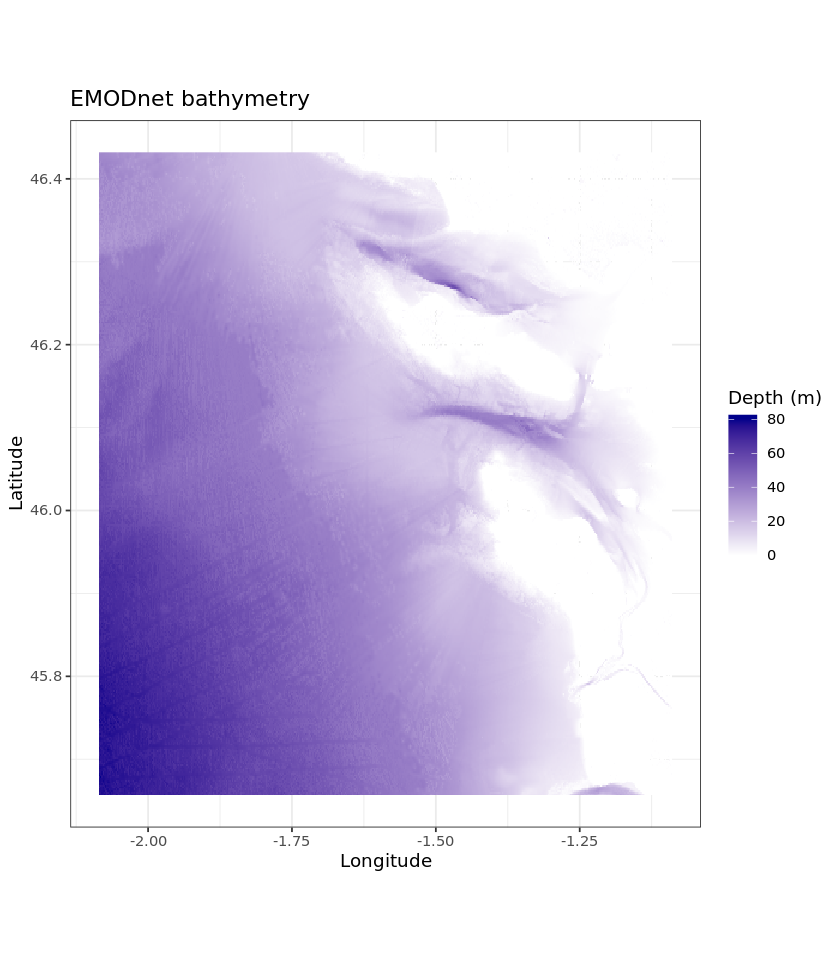

In [5]:
map <- ggplot(aes(x=x, y=y, z=emodnet.mean), data = bathy) +
  geom_raster(data=bathy, aes(fill=emodnet.mean)) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet bathymetry")+xlab("Longitude")+ylab("Latitude") +
  theme_bw()

map

We can overlie the bathymetry with the shape of the MPA

Regions defined for each Polygons



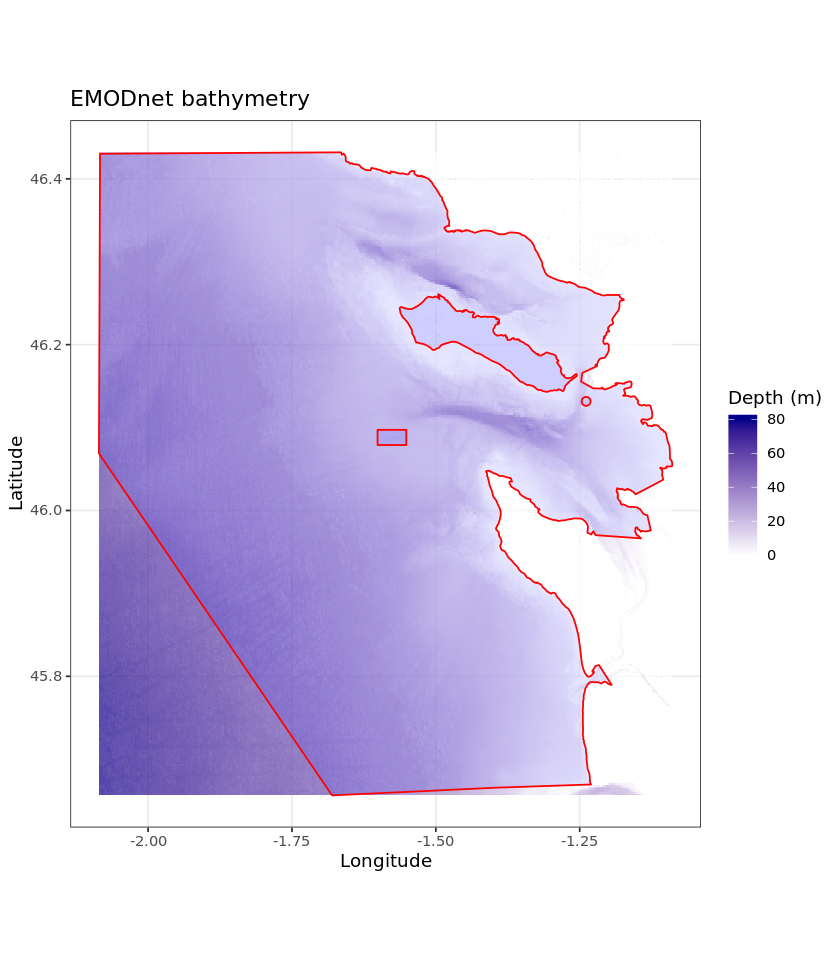

In [6]:
map_mpa <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="red",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet bathymetry")+xlab("Longitude")+ylab("Latitude") 
 
map_mpa

We can also calculate and plot isobaths.

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


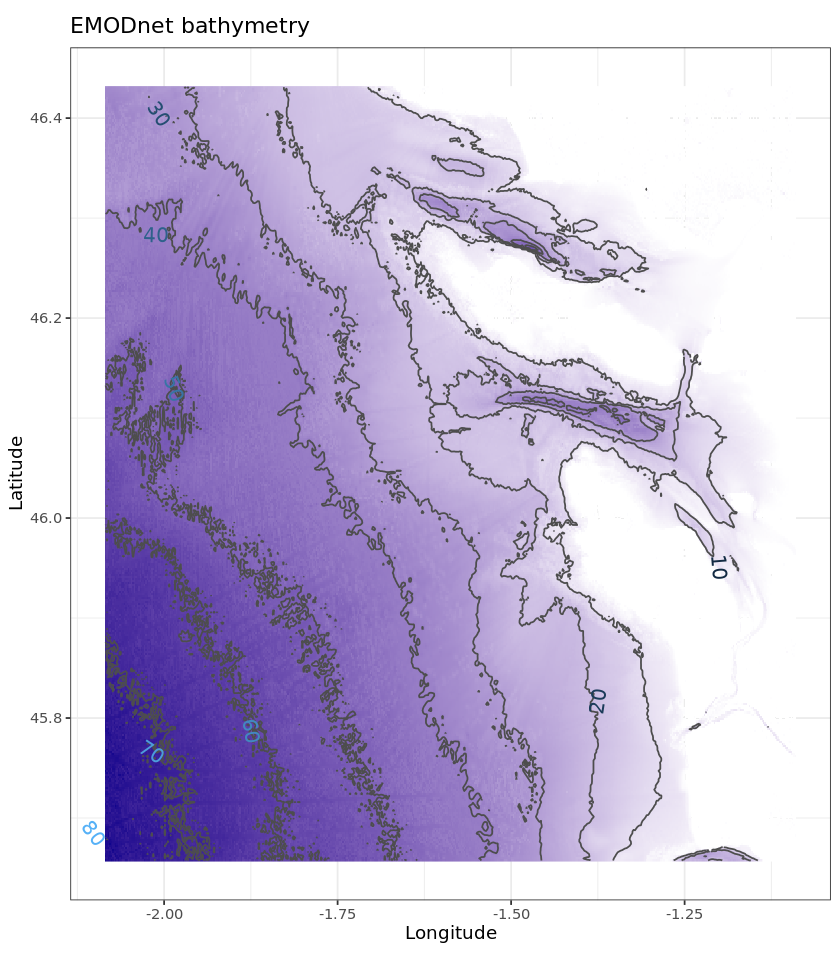

In [7]:
map_iso	<- map + geom_contour(aes(colour = ..level..), color='gray30', na.rm=T, show.legend=T)
map_isobath = direct.label(map_iso, list("far.from.others.borders", "calc.boxes", "enlarge.box", 
      hjust = 1, vjust = 1, box.color = NA, fill = "transparent", "draw.rects"))
map_isobath

For mapping raster data, we can also use the `rasterVis` package to create level plots.

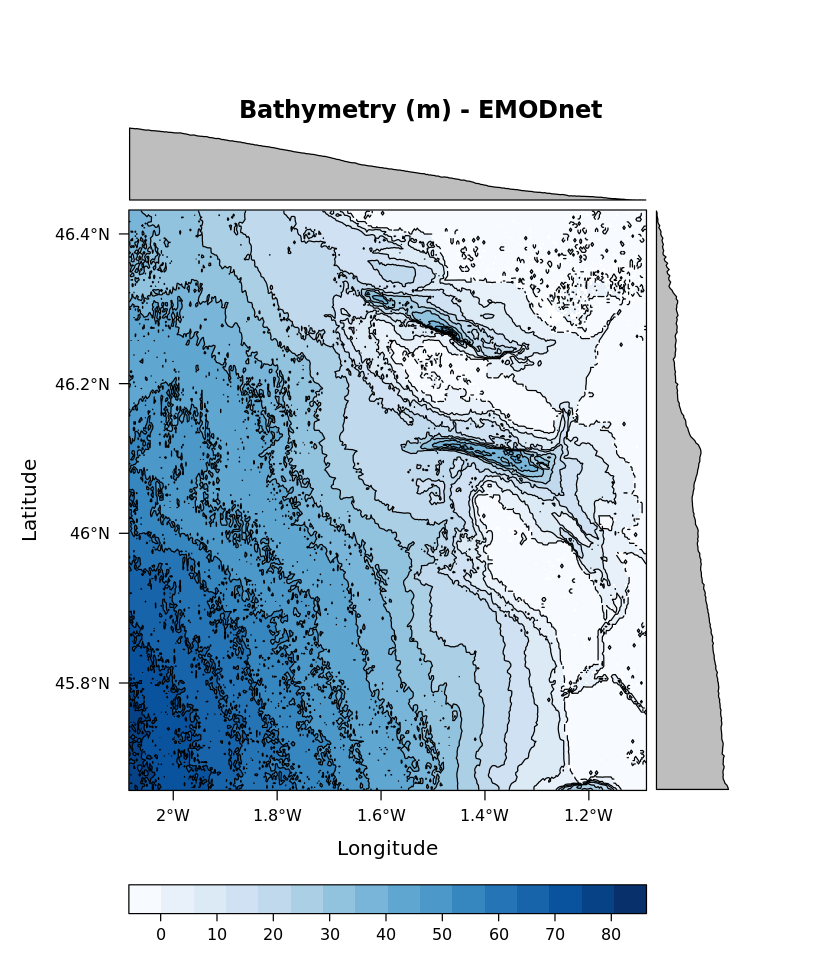

In [8]:
pltbathy <- rasterVis::levelplot(bathy_img, margin = TRUE, contour=T, main="Bathymetry (m) - EMODnet",
                                 par.settings=rasterTheme(region=brewer.pal('Blues', n=9)))
pltbathy

## Creating 3D visualisations

Using the `persp()` function we can also make 3D visualisations.

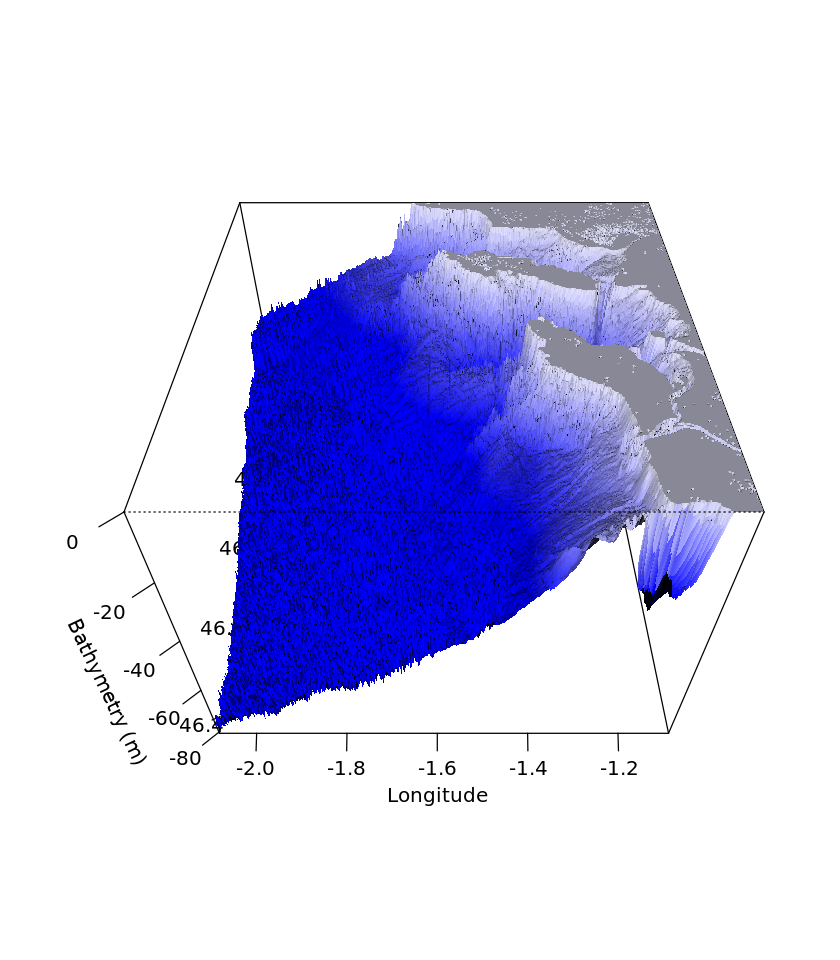

In [9]:
bathymetry.col<-function (n, alpha = 1){
  if ((n <- as.integer(n[1L])) > 0){
    j <- n%/%3
    k <- n%/%3
    i <- n - j - k
    c(if (i > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = i), alpha = alpha),
      if (j > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = j), alpha = alpha),
      if (k > 0) hsv(h = seq.int(from = 40/60, to = 40/60, length.out = k), alpha = alpha, s = seq.int(from = 1, to = 0.1, length.out = k),v = 1))
  }
  else character()
}

bathymetry3d <- -1*bathy_img
bathymetry3d[is.na(bathymetry3d)] <- 0
bathymetry3d[bathymetry3d > 0] <- 0

summary.elev <- summary(bathymetry3d)
setBaseElev <- function(x) {
  x[is.na(x)] <- as.numeric(summary.elev[1])
  return(x)
}
elev3D <- calc(bathymetry3d, setBaseElev)
zBathy <-round(as.matrix(elev3D),1)
y <- dim(zBathy)[1]
x <- dim(zBathy)[2]

nlat <- y
nlon <- x

nrz <- nrow(zBathy)
ncz <- ncol(zBathy)
zfacet <- (zBathy[-1, -1] + zBathy[-1, -ncz] + zBathy[-nrz, -1] + zBathy[-nrz, -ncz])/4
nbcol <- 254
color <- c("grey", bathymetry.col(nbcol))
facetcol <- cut(zfacet, nbcol+1)

steplat=(ymax-ymin)/nlat
steplon=(xmax-xmin)/nlon

latitude <- numeric(nlat)
for(i in 1:nlat){
  latitude[i]<-ymin+(i+0.5)*steplat
}

longitude <- numeric(nlon)
for(i in 1:nlon){
  longitude[i]<-xmin+(i+0.5)*steplon
}

img3d<- persp(latitude, longitude, z = zBathy, theta = 90, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="Longitude", zlab="Bathymetry (m)")

## Exporting graphics 

The maps and 3D visualisation can be exported to images (e.g. PNG's).

In [10]:
# determine dimensions of the images
width <- 960
height <- as.integer(width * (ymax-ymin) / (xmax-xmin))

#create unique id for the filenames
Sessionid = "OSLII_"

# output maps
png(file=paste(Sessionid,"_bathymetry2d_isobath.png",sep=""), width, height)
print(map_isobath)
dev.off()

png(file=paste(Sessionid,"_bathymetry2d_isobath_alt.png",sep=""), width, height)
print(pltbathy)
dev.off()

# output 3d visualisations

png(file=paste(Sessionid,"_bathymetry3d_90.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 90, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

png(file=paste(Sessionid,"_bathymetry3d_0.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 0, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

png(file=paste(Sessionid,"_bathymetry3d_180.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 180, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()


png(file=paste(Sessionid,"_bathymetry3d_270.png",sep=""), width, height)
img3d<- persp(latitude, longitude, z = zBathy, theta = 270, phi = 45, col = color[facetcol], scale = T, expand = 0.75, ltheta = 75, shade = 0.75, border = NA, box = T, ticktype = "detailed", xlab="", ylab="", zlab="Bathymetry (m)")
print(img3d)
dev.off()

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


png 
  2

png 
  2

              [,1]          [,2]          [,3]          [,4]
[1,]  1.583326e-16 -1.828414e+00  1.828414e+00 -1.828414e+00
[2,]  2.011553e+00  1.741917e-16 -2.465190e-32  2.465190e-32
[3,] -1.139560e-18  1.315956e-02  1.315956e-02 -1.315956e-02
[4,]  3.188656e+00  8.472202e+01 -8.639341e+01  8.739341e+01


png 
  2

            [,1]       [,2]        [,3]        [,4]
[1,]    2.585768 0.00000000  0.00000000  0.00000000
[2,]    0.000000 1.42238277 -1.42238277  1.42238277
[3,]    0.000000 0.01315956  0.01315956 -0.01315956
[4,] -119.065027 2.78505060 -4.45644123  5.45644123


png 
  2

              [,1]          [,2]         [,3]          [,4]
[1,] -2.585768e+00 -2.239161e-16 2.239161e-16 -2.239161e-16
[2,]  2.463442e-16 -1.422383e+00 1.422383e+00 -1.422383e+00
[3,] -1.395558e-34  1.315956e-02 1.315956e-02 -1.315956e-02
[4,]  1.190650e+02 -1.724390e+00 5.299979e-02  9.470002e-01


png 
  2

              [,1]          [,2]          [,3]          [,4]
[1,] -4.749978e-16  1.828414e+00 -1.828414e+00  1.828414e+00
[2,] -2.011553e+00 -1.741917e-16  3.483833e-16 -3.483833e-16
[3,]  1.139560e-18  1.315956e-02  1.315956e-02 -1.315956e-02
[4,] -3.188656e+00 -8.366136e+01  8.198997e+01 -8.098997e+01


png 
  2

## Summarising raster data

From the raster data, we can derive statistics like the average depth and the standard deviations.

In [11]:
values <- getValues(bathy_img$emodnet.mean)

# calcualte the average depth
m <- mean(values,na.rm=T)
m

# calculate the standard deviation
std_dev <- sd(values,na.rm=T)
std_dev

[1] 26.38184

[1] 21.40382

## Exporting data

### Exporting raster data

Using the `ncdf4` package, we can export the raster data to the netCDF format. The created netCDF file can then be used in other applications like [Panoply](https://www.giss.nasa.gov/tools/panoply/download).

In [12]:
writeRaster(bathy_img, "EMODnet_bathymetry_555526224.nc", format="CDF", force_v4=TRUE, compression=7, overwrite=TRUE)

class      : RasterLayer 
dimensions : 372, 478, 177816  (nrow, ncol, ncell)
resolution : 0.002084396, 0.00208481  (x, y)
extent     : -2.085426, -1.089085, 45.65643, 46.43198  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /home/jovyan/R-tutorial/EMODnet_bathymetry_555526224.nc 
names      : emodnet.mean 
values     : 0, 80.6  (min, max)
zvar       : emodnet.mean 


### Exporting vector data

The MPA shapefile can be exported in geoJSON format

In [13]:
writeOGR(mpa,dsn = "mpa.json", layer="mpa",driver="GeoJSON")

ERROR: Error in writeOGR(mpa, dsn = "mpa.json", layer = "mpa", driver = "GeoJSON"): layer exists, use a new layer name


## Accessing the original survey data

The EMODnet bathymetry data we have used throughout this exercise is a dataproduct that was calculated from a number of individual bathymetric surveys. In case we want to find the original survey data, EMODnet bathymetry provides a dataset with the outline of each of the individual surveys as well as their identification. In the script below, we access this source reference (vector) data using WFS (see Exercise 2) and investigate the different surveys in the MPA.

In [ ]:
# define a function to access the survey vector data using WFS
getDTMgeojson<-function(name="DTM_Surveys",xmin=-1,xmax=1,ymin=49,ymax=50){
  name<-as.character(name)
  bbox<-paste(xmin,ymin,xmax,ymax,sep=",")
  con<-paste0("https://ows.emodnet-bathymetry.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=",
  name,"&OUTPUTFORMAT=json&bbox=",bbox)
  ogrInfo(dsn=con,layer = 'OGRGeoJSON')
  layer<-readOGR(dsn=con,layer = 'OGRGeoJSON')
  print(con)
  return(layer)
}

# load the data
DTM_Surveys<-getDTMgeojson(name="emodnet:source_references",xmin,xmax,ymin,ymax)

#create a data frame to plot identifier on top of polygons
centroid <- aggregate(coordinates(DTM_Surveys) ~ identifier, data=DTM_Surveys, FUN=mean)
names(centroid) <- c("Name", "Longitude", "Latitude")

map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  # annotate("text", x=-1.5, y=46, label= "boat") +
  geom_polygon(data=DTM_Surveys,aes(x=long,y=lat,group=group,fill="DTM_Surveys"),colour="green",fill=NA) +
  # geom_text(check_overlap = TRUE) +
  geom_text(data=centroid, aes(label = Name, x = Longitude, y = Latitude), size=2, check_overlap = TRUE) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
  ggtitle("DTM surveys")+xlab("Longitude")+ylab("Latitude")

map

Finally, we export the survey dataset to a shapefile.

In [ ]:
writeOGR(DTM_Surveys,dsn = "DTM_Surveys", layer="Survey_outlines",driver="ESRI Shapefile", overwrite_layer = TRUE)

# Working with data from EMODnet human activities

## Access vector data with WFS

The WFS of the EMODnet Human Activities portal allows collecting all kind of information for the MPA.

https://ows.emodnet-humanactivities.eu/wfs?service=WFS&request=GetCapabilities&version=1.1.0

### Point data

In this tutorial, we access point data from EMODnet Human Activities within the desired region of interest (the MPA) as a csv file.

To get/read the names of the columns of the layer (in this case "shellfish"):

* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=describeFeatureType&typeName=shellfish&OUTPUTFORMAT=application/json&bbox=-1.3,0.3,49.2,49.9
* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=describeFeatureType&typeName=shellfish&bbox=-1.3,0.3,49.2,49.9
* https://ows.emodnet-humanactivities.eu/wfs?service=wfs&version=2.0.0&request=DescribeFeatureType
* https://ows.emodnet-humanactivities.eu/wfs?service=wfs&version=2.0.0&request=GetPropertyValue&typeNames=shellfish&valueReference=the_geom&bbox=-1.3,0.3,49.2,49.9

Note: featureID and bbox are mutually exclusive:

* https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=shellfish&OUTPUTFORMAT=csv&bbox=-1.3,0.3,49.2,49.9&featureID=the_geom

In [ ]:
# define a function to download the WFS data as a csv file 
gethumactpoint<-function(name="shellfish",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name <- as.character(name)
  bbox <- paste(xmin,xmax,ymin,ymax,sep=",")
  con <- paste0("https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo <- utils::read.csv("dat.csv")
  # if no data return empty dataframe
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  # convert coordinates to numeric type
  else{
    xy <- strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$the_geom)),split=" ")
    fun1 <- function(a){as.numeric(a[1])}
    fun2 <- function(a){as.numeric(a[2])}
    pipo$y <- sapply(xy,fun1)
    pipo$x <- sapply(xy,fun2)
    return(pipo)
  }
}

# function to format the dataframe
gethumactpointall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9)
{
  layer="shellfish"
  #layer="windfarmspoly"
  #layer="windfarms"
  #layer="subunitcatches"
  #layer="subdivisioncatches"
  #layer="subareacatches"
  #layer="sigcables"
  #layer="portvessels"
  #layer="macroalgae"
  #layer="aggregates"
  
  # get csv file
  rez0 <- gethumactpoint(layer, ymin, xmin, ymax, xmax)
  # format dataframe
  if (nrow(rez0) > 0){
    ha <- data.frame(type = layer,
                     status = rez0$status,
                     purpose = rez0$purpose,
                     info = rez0$species,
                     name = rez0$area_name,
                     country = rez0$country,
                     x = rez0$x,
                     y = rez0$y)
    rm(rez0)
  }
  return(ha)
}

# get the shellfish data 
ha<-gethumactpointall(xmin,xmax,ymin,ymax)


Investigate the downloaded data table and plot them on a map.

In [ ]:
ha %>% knitr::kable(floating.environment="sidewaystable") %>%  as.character() %>% display_html()

In [ ]:
map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_point(data=ha,aes(x=x,y=y),alpha=.5,color="red", size=2) +
  geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("Human activities")+xlab("Longitude")+ylab("Latitude")

map

We can also combine several data layers in one table.

In [ ]:
# a function to format and combine data from different layers
gethumactpointall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  ha <- data.frame()
  rez0 <- gethumactpoint("finfish", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "finfish", status = rez0$status,
    purpose = rez0$purpose, info = rez0$species_detailed,
    name = rez0$owner_name, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("shellfish", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "shellfish", status = rez0$status,
    purpose = rez0$purpose, info = rez0$species, name = rez0$area_name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("dredging", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "dredging", status = rez0$purpose,
    purpose = rez0$extraction_type, info = rez0$extraction_area,
    name = rez0$areaid, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("hydrocarbons", ymin, xmin, ymax,
  xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "hydrocarbons", status = rez0$status,
    purpose = rez0$purpose, info = rez0$company, name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("aggregates", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "aggregates", status = rez0$notes,
    purpose = rez0$purpose, info = rez0$extraction_type,
    name = rez0$extraction_area, country = rez0$country,
    x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("platforms", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "platforms", status = rez0$class,
    purpose = rez0$primary_production, info = rez0$category,
    name = rez0$name, country = rez0$country, x = rez0$x,
    y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("windfarms", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "windfarms", status = rez0$status,
    purpose = rez0$power_mw, info = "", name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("dredgespoil", ymin, xmin, ymax, xmax)
    if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "dredgespoil", status = "",
    purpose = "", info = rez0$oscom_code, name = rez0$name,
    country = rez0$country, x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }
  rez0 <- gethumactpoint("munitions", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    ha1 <- data.frame(type = "munitions", status = "", purpose = "",
    info = rez0$munition_type, name = "", country = "",
    x = rez0$x, y = rez0$y)
    ha <- rbind(ha, ha1)
    rm(rez0)
  }

return(ha)
}

# get the data
ha <- gethumactpointall(xmin,xmax,ymin,ymax)

Plot the human activity data on map with the EMODnet bathymetry and the coastline data from the `mapdata` package. 

In [ ]:
map <- ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  borders("worldHires",xlim=c(xmin,xmax),ylim=c(ymin,ymax),fill="light grey",colour="light grey") + 
  geom_point(data=ha,aes(x=x,y=y,shape=type,group=type),colour="red",alpha=1, size=4) +
  #geom_polygon(data=mpa,aes(x=long,y=lat,group=group,fill="mpa"),colour="green",fill="blue",alpha=.1)+
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax))+
  ggtitle("Human activities")+xlab("Longitude")+ylab("Latitude")

plot(map)

Finally, we export the point data to a csv file.

In [ ]:
write.csv(ha, file = "Humanactivities.csv", row.names = FALSE)

### Polygon data

We can also access polygon data as a geoJSON file with WFS. Here we download the natura2000 sites.

In [ ]:
# define a function to read the WFS data as a geoJSON file
gethumactgeojson<-function(name="natura2000areas",xmin=-1,xmax=1,ymin=49,ymax=50){
  name <- as.character(name)
  bbox <- paste(xmin,ymin,xmax,ymax,sep=",")
  con <- paste0("https://ows.emodnet-humanactivities.eu/wfs?SERVICE=WFS&VERSION=1.0.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=application/json&bbox=",bbox)
  ogrInfo(dsn=con,layer = 'OGRGeoJSON')
  layer <- readOGR(dsn=con,layer = 'OGRGeoJSON')
  print(con)
  return(layer)
}

# get data
natura2000 <- gethumactgeojson(name="natura2000areas",xmin,xmax,ymin,ymax)

We can now overlay our map with the natura2000 sites.

In [ ]:
map <- ggplot()+
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data=ha,aes(x=x,y=y,shape=type,group=type),colour="red", alpha=1, size=4) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="green",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("Natura 2000 poly")+xlab("Longitude")+ylab("Latitude")

map

Finally, we export the polygon data to a geoJSON file.

In [ ]:
writeOGR(natura2000, dsn = 'natura2000.json', layer="natura2000",driver="GeoJSON")

## Access raster time series data with WCS

EMODnet human activities offers monthly datasets of vessel density for each type of vessel. With the script below we are downloading the vessel density data  for each month and each vessel type using the EMODnet human activities WCS.

In [ ]:
# define a function to access vessel density data from the EMODnet human activities WCS
getvesseldensityLite <- function(name = "emodnet:2017_01_st_All", resolution = "30 arcsec / 900m", xmin = 15, xmax = 20.5, ymin = 30, ymax = 32.5){
  bbox <- paste(xmin, ymin, xmax, ymax, sep = ",")                           
  con <- paste("https://ows.emodnet-humanactivities.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",name,"&crs=EPSG:4326&BBOX=", bbox, "&format=image/tiff&interpolation=nearest&resx=0.00833333&resy=0.00833333", sep = "") 
  nomfich <- paste(name, "img.tiff", sep = "_")
  nomfich <- tempfile(nomfich)
  download(con, nomfich, quiet = TRUE, mode = "wb")
  img <- raster(nomfich)
  img[img == 0] <- NA
  names(img) <- paste(name)
  return(img)
}

# define a function to make a rasterstack of monhtly vessel density data
createmonthlystack <- function(name = "emodnet:2017_",
                               vessel_type = "All",
                               resolution  = "30 arcsec",
                               xmin = 15, xmax = 20.5,
                               ymin = 30, ymax = 32.5){
  imgs <- stack()
  for (month in c('01','02','03','04','05','06','07','08','09','10','11','12')){
    img <- getvesseldensityLite(name = paste(name,month,"_st_",vessel_type, sep=""), resolution = resolution, xmin, xmax, ymin, ymax)
    imgs <- stack(imgs,img)
  }
  return(imgs)
}

# create dataframe of vessel types
vesseltypes <- cbind.data.frame(type_id = c('All','00','01','02','03','04','05','06','07','08','09','10','11','12'),
                             type_name = c("ALL","OTHER","FISHING","SERVICE","DREDGING","SAILING","PLEASURE",
                                                 "HIGHSPEED","TUG","PASSENGER","CARGO","TANKER","MILITARY","UNKNOWN"),
                             stringsAsFactors=FALSE)

# loop over the different vessel types and create a stack for each one, combining them in a list
mpa_vessel_density_per_type = list()
for(i in 1:nrow(vesseltypes)){
  mpa_vessel_density_per_type[[vesseltypes[i,"type_name"]]] = createmonthlystack(vessel_type = vesseltypes[i,"type_id"],
                                                                               xmin = xmin, xmax=xmax,
                                                                               ymin = ymin, ymax=ymax)
}

We visualise these data by making monthly maps as well as a yearly average for a selected vessel type.

In [ ]:
# define a function to map the density maps, average yearly density and monthly climatology
mpaprocessplot<-function (imgs, mpa, name, unite, logscale) 
{
    if (dim(imgs)[3] < 12) {
        print("Series is too short (ie less than 12 months)")
    }
    else {
  		col.l <- colorRampPalette(c('white','cadetblue1','blue','cyan','green','yellow','orange','red','black'))
  		#col.l <- colorRampPalette(c('blue','cyan','green','yellow','orange','red','black'))
  		#imgs[imgs > 100] <- 100
  		ckey <- list(labels=list(cex=1.6, col='black'), height=1.0)
	
      imgsmean <- raster::mean(imgs, na.rm = T)

  	  
      
      # plot monthly data
      titre <- paste(name, " (", unite, ")", sep = "")
      pltall <- rasterVis::levelplot(imgs,
                                     zscaleLog = logscale, contour = F, 
                                     col.regions = col.l, colorkey=ckey,
                                     layout = c(4, NA),
                                     names = sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)),
                                     main=list(label=titre, cex=1))
  
      titre <- paste(name, " (", unite, ") ",
                     sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)[1]),
                     "-",
                     sub(".*(2017)_([0-9]{2})_.*","\\1.\\2",names(imgs)[dim(imgs)[3]]),
                     " average", sep = "")
      pltmean <- rasterVis::levelplot(imgsmean, margin = F,
                                      zscaleLog = logscale,contour = F,
                                      col.regions = col.l,  colorkey=ckey,
                                      main=list(label=titre, cex=1)) +
      contourplot(imgsmean, at = c(0,1,10,20,40,60) , labels = T)
  	
      titre <- paste(name, " (", unite, ") monthly boxplot", sep = "")
      pltbw <- rasterVis::bwplot(crop(imgs, extent(mpa)),logscale = T,
          scales = list(x = list(labels = names(imgs))), 
          main=list(label=titre, cex=1))
      
      return(list(pltall = pltall,
                  pltmean = pltmean,
                  pltbw = pltbw))
      }
}

# get a coastline shape
mappoly<-map("worldHires",fill=T,plot=FALSE,xlim=c(extent(mpa)@xmin-1,extent(mpa)@xmax+1),ylim=c(extent(mpa)@ymin-1,extent(mpa)@ymax+1))
IDs <- sapply(strsplit(mappoly$names, ":"), function(x) x[1])
coast<- map2SpatialPolygons(mappoly, IDs=IDs, proj4string=CRS("+proj=longlat +datum=WGS84"))

# make plots for the desired vessel types
types_to_plot= c("SAILING")
for(type in types_to_plot){
  plt_vessel <- mpaprocessplot(imgs = mpa_vessel_density_per_type[[type]],
                               mpa=mpa,
                               name=paste("Vessel density",type, sep=" - "),unite="hours/month",
                               logscale= !(type %in% c("HIGHSPEED","UNKNOWN"))) # too little data in these types to have a logscale
  #print map of the whole series
  img1 <- plt_vessel[[1]]+latticeExtra::layer(sp.polygons(coast,fill="grey",col="grey"))+latticeExtra::layer(sp.polygons(mpa))
  print(img1)
  #print map of the average 
  img2 <- plt_vessel[[2]]+latticeExtra::layer(sp.polygons(coast,fill="grey",col="grey"))+latticeExtra::layer(sp.polygons(mpa))
  print(img2)
  
  # save images as PNG
  png(file=paste("VESSEL_monthly_composite-",type,".png",sep=""),width = 960, height = 960)
  print(img1)
  dev.off()

  png(file=paste("VESSEL_average-",type,".png",sep=""),width = 960, height = 960)
  print(img2)
  dev.off()
}

Let's derive the average vessel density per month for our MPA.

In [ ]:
# get the area of the mpa
mpa$area_sqkm <- area(mpa)/1000000

# extract the average fishing density in the mpa for each vessel type and month
data_csv = data.frame(MONTH = c(01,02,03,04,05,06,07,08,09,10,11,12))
for(type in vesseltypes$type_name){
  monthly_means = c()
  for(month in 1:12){
    datinpoly <- raster::extract(mpa_vessel_density_per_type[[type]][[month:month]],mpa,df = TRUE, cellnumbers = TRUE)
    tabdat <- as.vector(as.matrix(datinpoly[, 3:ncol(datinpoly)]))
    mean_value <- sum(tabdat, na.rm = T)/mpa$area_sqkm
    monthly_means = c(monthly_means, mean_value)
  }
  data_csv[type]= monthly_means
}

# export the data
#write.csv(data_csv, file="mpa_monthly_average_density_per_type", row.names=FALSE, na="NaN")

Let us plot the time series of the averaged vessel density data.

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
df <- melt(data_csv ,  id.vars = 'MONTH', variable.name = 'series')
# ggplot(df, aes(MONTH,value)) + geom_line() + facet_grid(series ~ .) + theme_bw()
ggplot(df, aes(MONTH,value)) + geom_line(aes(colour = series)) + theme_bw()

# Working with data from EMODnet physics

## EMODnet physics WFS

The [WFS](https://geoserver.emodnet-physics.eu/geoserver/emodnet/ows?service=WFS&request=GetCapabilities&version=1.0.0) of the EMODnet Physics portal offers the possibility to identify the existing in-situ measurements for the region of interest (bbox).

In [ ]:
# define a function to download point data as csv from the EMODnet physics WFS
getEMODnetPhysicsplatform<-function(name="EP_PLATFORMS_SLEV",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name<-as.character(name)
  bbox<-paste(xmin,xmax,ymin,ymax,sep=",")
  con<-paste0("http://geoserver.emodnet-physics.eu/geoserver/emodnet/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo<-utils::read.csv("dat.csv")
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  else{
    xy<-strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$position)),split=" ")
    fun1<-function(a){as.numeric(a[1])}
    fun2<-function(a){as.numeric(a[2])}
    pipo$y<-sapply(xy,fun1)
    pipo$x<-sapply(xy,fun2)
    print(con)
    return(pipo)
  }

}

# define a function to combine different data layers in a dataframe
getEMODnetPhysicsplatformall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  physics <- data.frame()
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_SLEV", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_SLEV", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_WIND", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_WIND", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_WAVE", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_WAVE", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_TEMP", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_TEMP", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_HCXX", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_HCXX", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_MO", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_MO", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_HFR", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_HFR", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_FB", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_FB", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }
  
  rez0 <- getEMODnetPhysicsplatform("EP_PLATFORMS_GL", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    physics1 <- data.frame(type = "EP_PLATFORMS_GL", status = rez0$ProjectsDescr,
    purpose = rez0$ParametersGroupDescr, info = rez0$DataOwner, name = rez0$PlatformID, PltLink = rez0$PlatformInfoLink,
    country = rez0$Country, x = rez0$x, y = rez0$y)
    physics <- rbind(physics, physics1)
    rm(rez0)
  }

return(physics)
}

# get the data in the MPA
physics<-getEMODnetPhysicsplatformall(xmin,xmax,ymin,ymax)

We now plot the EMODnet physics data on a map and export the data to a CSV file.


In [ ]:
map<-ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data= physics,aes(x=x,y=y,shape=type,group=type),colour="green", alpha=1, size=4) +
  #geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet Physics Platforms")+xlab("Longitude")+ylab("Latitude")
plot(map)



write.csv(physics, file = "EMODnetPhysics.csv")

## Alternative EMODnet physics web services

* UniqueURL (netCDF, metadata, )

  + https://www.emodnet-physics.eu/map/platinfo/piradar.aspx?platformid=10273
  + https://www.emodnet-physics.eu/map/platinfo/pidashboard.aspx?platformid=10273


* Service description @

  + https://www.emodnetphysics.eu/map/spi.aspx


* API (REST, SOAP) web services [latest 60 days of data]

  + www.emodnet-physics.eu/map/Service/WSEmodnet2.aspx
  + www.emodnet-physics.eu/map/service/WSEmodnet2.asmx
 
 
* OGC (WMS, WFS, …)

  + https://geoserver.emodnet-physics.eu/geoserver/emodnet/ows



* Opendap/THREDDS [HFR data, Ice, climatologies] (netCDF)

  + https://thredds.emodnet-physics.eu/thredds/catalog.html
  + Unidata's THREDDS Data Server (TDS) is a web server that provides metadata and data access for scientific datasets, using OPeNDAP, OGC WMS and WCS, HTTP, and other remote data access protocols.


* ERDDAP [latest 60 days of data]

  + https://erddap.emodnet-physics.eu/erddap/index.html
  + ERDDAP is a data server that gives you a simple, consistent way to download subsets of scientific datasets in common file formats and make graphs and maps. This particular ERDDAP installation has oceanographic data (for example, data from satellites and buoys).


* Widgets:

  + https://www.emodnet-physics.eu/Map/Charts/PlotDataTimeSeries.aspx?paramcode=TEMP&platid=8427&timerange=7

<iframe src ="https://www.emodnet-physics.eu/Map/Charts/PlotDataTimeSeries.aspx?paramcode=TEMP&platid=8427&timerange=7" height=500px width=800px />



# Working with data from EMODnet seabed habitats and EMODnet geology


## Access map layers with WMS

In this exercise, we will gather information on the seafloor using the WMS of EMODnet seabed habitats and EMODnet geology:

* https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?service=WMS&request=GetCapabilities&version=1.1.0

* https://drive.emodnet-geology.eu/geoserver/tno/wms?service=WMS&request=GetCapabilities&version=1.1.0

### EUNIS classification (EMODnet seabed habitats)

In the script below, we download the EUNIS classification map image.


In [ ]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?layers=eusm2019_group&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

In [ ]:
# define fucntion to plot the image
rggbplot <- function(inRGBRst,npix=NA,scale = 'lin'){
 
  rgblinstretch <- function(rgbDf){
    maxList <- apply(rgbDf,2,max)
    minList <- apply(rgbDf,2,min)
    temp<-rgbDf
    for(i in c(1:3)){
      temp[,i] <- (temp[,i]-minList[i])/(maxList[i]-minList[i])
    }
    return(temp)
  }
 
  rgbeqstretch<-function(rgbDf){
 
    temp<-rgbDf
    for(i in c(1:3)){
      unique <- na.omit(temp[,i])
      if (length(unique>0)){
        ecdf<-ecdf(unique)
        temp[,i] <- apply(temp[,i,drop=FALSE],2,FUN=function(x) ecdf(x))
      }
    }
    return(temp)
  }
 

      npix <- ncell(inRGBRst)

  x <- sampleRegular(inRGBRst, size=npix, asRaster = TRUE)
  dat <- as.data.frame(x, xy=TRUE)
  colnames(dat)[3:5]<-c('r','g','b')
 
  if(scale=='lin'){
    dat[,3:5]<- rgblinstretch(dat[,3:5])
  } else if(scale=='stretch'){
    dat[,3:5]<- rgbeqstretch(dat[,3:5])
  }
  p <- ggplot()+ geom_tile(data=dat, aes(x=x, y=y, fill=rgb(r,g,b))) + scale_fill_identity()
 
}

# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Seabed Habitats - EUNIS classification")+xlab("Longitude")+ylab("Latitude")
map

### Biological zone (EMODnet seabed habitats)

In the script below, we download the biological zone map image.

In [ ]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://ows.emodnet-seabedhabitats.eu/emodnet_view/ows?layers=eusm2019_bio_group&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

In [ ]:
# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Seabed Habitats - Biological zone")+xlab("Longitude")+ylab("Latitude")
map

### Seabed substrate (EMODnet geology)

In the script below, we download the seabed substrate map image.

In [ ]:
# determine width and height of the WMS image to download
width <- 960
height <- as.integer(width * (extent(mpa)@ymax-extent(mpa)@ymin) / (extent(mpa)@xmax-extent(mpa)@xmin)) 

bbox <- paste(extent(mpa)@xmin, extent(mpa)@ymin, extent(mpa)@xmax, extent(mpa)@ymax, sep = ",")

# download the image
con <- paste0("https://drive.emodnet-geology.eu/geoserver/gtk/wms?layers=seabed_substrate_1m&bbox=", bbox,
"&service=WMS&format=image/png&interpolation=nearest&srs=EPSG:4326&request=GetMap&height=",height,"&width=",width,"")
download(con, "img.png", quiet = TRUE, mode = "wb")
img <- brick("img.png")

# set extent and determine map projection
img@extent@xmin <- xmin
img@extent@ymin <- ymin
img@extent@xmax <- xmax
img@extent@ymax <- ymax
proj4string(img)<-CRS("+proj=longlat +datum=WGS84")

Now we can add the downloaded and georeferenced image to our MPA map.

In [ ]:
# draw the map
map <- rggbplot(img) +
  theme_bw() +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  geom_polygon(data=natura2000,aes(x=long,y=lat,group=group,fill="natura2000"),colour="red",fill="blue",alpha=.1) +
  ggtitle("EMODnet Geology - Seabed substrate")+xlab("Longitude")+ylab("Latitude")
map

## Access point data with WFS

In this exercise we access the coastal migration point data from the EMODnet geology WFS within the desired region of interest (the MPA) as a csv file.

In [ ]:
# define a function to download the WFS data as a csv file 
getEMODnetCoastalMigration<-function(name="tno:coastal_migration_satellite_0_40k",xmin=-1000,xmax=1000,ymin=-1000,ymax=1000){
  name<-as.character(name)
  bbox<-paste(xmin,xmax,ymin,ymax,sep=",")
  con<-paste0("https://drive.emodnet-geology.eu/geoserver/tno/wfs?SERVICE=WFS&VERSION=1.1.0&request=GetFeature&typeName=",
  name,"&OUTPUTFORMAT=csv&bbox=",bbox)
  utils::download.file(con,"dat.csv", quiet = TRUE, mode = "wb")
  pipo<-utils::read.csv("dat.csv")
  if(ncol(pipo)<=1){
    return(data.frame())
  }
  else{
    xy<-strsplit(gsub("\\)","",gsub("POINT \\(","",pipo$geom)),split=" ")
    fun1<-function(a){as.numeric(a[1])}
    fun2<-function(a){as.numeric(a[2])}
    pipo$y<-sapply(xy,fun1)
    pipo$x<-sapply(xy,fun2)
    print(con)
    return(pipo)
  }
}

# function to format the dataframe
getEMODnetCoastalMigrationformall<-function (xmin = -1.3, xmax = 0.3, ymin = 49.2, ymax = 49.9){
  geology <- data.frame()
  rez0 <- getEMODnetCoastalMigration("tno:coastal_migration_satellite_0_40k", ymin, xmin, ymax, xmax)
  if (nrow(rez0) > 0){
    geology1 <- data.frame(type = "tno:coastal_migration_satellite_0_40k", Migration = rez0$changerate, name = rez0$id,
    x = rez0$x, y = rez0$y)
    geology <- rbind(geology, geology1)
    rm(rez0)
  }
  return(geology)
}

# get the data
geology<-getEMODnetCoastalMigrationformall(xmin,xmax,ymin,ymax)

We now plot the coastal migration data on a map and export the data to a CSV file.

In [ ]:
# make a map
map<-ggplot() +
  theme_bw() +
  theme(panel.grid.minor.y= element_blank(), panel.grid.minor.x = element_blank()) +
  geom_raster(data=bathy,aes(x=x,y=y,fill=emodnet.mean),alpha=.75) +
  scale_fill_gradient(low = "white", high = "darkblue",name="Depth (m)") +
  geom_point(data= geology,aes(x=x,y=y,shape=type,group=type,color=Migration), alpha=1, size=2) +
  #scale_shape_manual(name = "Coastal Migration", values = c(4)) + 
  scale_colour_distiller(palette = "Spectral", limits = c(-50, 50)) +
  coord_quickmap(xlim=range(xmin,xmax),ylim=range(ymin,ymax)) +
  ggtitle("EMODnet Geology Coastal migration")+xlab("Longitude")+ylab("Latitude")

plot(map)

# export the data to csv
write.csv(geology, file = "EMODnetGeology-CoastalMigration.csv")

### [>> To part 2 of the tutorial](./EMODnet_web_services_in_R_part2.ipynb)

-----------------------------------------------------------------------------------------------------------
<center> Provided by EMODnet. See our <a href=https://emodnet.eu/en/terms-use> terms of use </a></center>
<center><a href="https://www.emodnet.eu/"><img style="float: None" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://www.emodnet.eu/sites/emodnet.eu/files/public/logo_2x_1.png" /></a>
</center>